# Import Dependencies

In [149]:
from datetime import datetime
from io import BytesIO
from sqlalchemy import create_engine, inspect, text
from time import time

import json
import locale
import numpy as np
import pandas as pd

import requests
import time as t
from geoalchemy2 import Geometry, WKTElement
import psycopg2
from shapely import wkb

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Database setup

Notes: put your postgresql configuration in the config.json file

In [153]:
with open('config.json') as config:
    db_config = json.load(config)

db_user = db_config['DB_USER']
db_password = db_config['DB_PASSWORD']
db_host = db_config['DB_HOST']
db_port = db_config['DB_PORT']
db_name = db_config['DB_NAME']

db_engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')
gh_inspector = inspect(db_engine)

# 2. Dataset 1: Greenhouse and energy information by designated generation facility

In [156]:
gh_energy_data_facts = [
    {
        "time_period_start": datetime(2023, 1, 7),
        "time_period_stop": datetime(2024, 6, 30),
        "dataset_id": "ID0243"
    },
    {
        "time_period_start": datetime(2022, 1, 7),
        "time_period_stop": datetime(2023, 6, 30),
        "dataset_id": "ID0083"
    },
    {
        "time_period_start": datetime(2021, 1, 7),
        "time_period_stop": datetime(2022, 6, 30),
        "dataset_id": "ID0082"
    },
    {
        "time_period_start": datetime(2020, 1, 7),
        "time_period_stop": datetime(2021, 6, 30),
        "dataset_id": "ID0081"
    },
    {
        "time_period_start": datetime(2019, 1, 7),
        "time_period_stop": datetime(2020, 6, 30),
        "dataset_id": "ID0080"
    },
    {
        "time_period_start": datetime(2018, 1, 7),
        "time_period_stop": datetime(2019, 6, 30),
        "dataset_id": "ID0079"
    },
    {
        "time_period_start": datetime(2017, 1, 7),
        "time_period_stop": datetime(2018, 6, 30),
        "dataset_id": "ID0078"
    },
    {
        "time_period_start": datetime(2016, 1, 7),
        "time_period_stop": datetime(2017, 6, 30),
        "dataset_id": "ID0077"
    },
    {
        "time_period_start": datetime(2015, 1, 7),
        "time_period_stop": datetime(2016, 6, 30),
        "dataset_id": "ID0076"
    },
    {
        "time_period_start": datetime(2014, 1, 7),
        "time_period_stop": datetime(2015, 6, 30),
        "dataset_id": "ID0075"
    }
]

gh_energy_table_name = "greenhouse_and_energy"

gh_energy_column_aliases = [
    {"reporting_entity": ["reportingentity", "reportingEntity", "controllingcorporation"]},
    {"facility_name" : ["facilityname", "facilityName"]},
    {"type": ["type"]},
    {"state": ["state"]},
    {"electricity_production_gj": ["electricityproductionGJ", "electricityProductionGJ"]},
    {"electricity_production_mwh" :["electricityproductionMWh", "electricityProductionMWh", "electricityProductionMwh"]},
    {"total_scope_1_emissions_t_co2_e": ["totalscope1emissionstCO2e", "totalScope1EmissionstCO2e", "scope1tCO2e"]},
    {"total_scope_2_emissions_t_co2_e": ["totalscope2emissionstCO2e", "totalScope2EmissionstCO2e", "totalScope2EmissionstCO2e2", "scope2tCO2e"]},
    {"total_emissions_t_co2_e": ["totalemissionstCO2e", "totalEmissionstCO2e"]},
    {"emission_intensity_t_co2_emwh": ["emissionintensitytCO2eMWh", "emissionIntensitytCO2eMWh", "emissionIntensitytMwh"]},
    {"grid_connected": ["gridconnected", "gridConnected", "gridConnected2"]},
    {"grid": ["grid"]},
    {"primary_fuel": ["primaryfuel", "primaryFuel"]},
    {"important_notes": ["importantnotes", "importantNotes"]},
    {"time_period_start": ["time_period_start"]},
    {"time_period_stop": ["time_period_stop"]},
    {"dataset_id": ["dataset_id"]} 
]

In [158]:
def standardize_column_name(df, col_name_aliases):
    col_names = df.columns.tolist()
    col_map = {}

    for col in col_names:
        for alias_dict in col_name_aliases:
            alias = list(alias_dict.values())[0]
            if col in alias:
                col_map[col] = list(alias_dict.keys())[0]
                break

    return df.rename(columns=col_map)

total_row_inserted = 0
for index, fact in enumerate(gh_energy_data_facts):
    # read csv
    dataset_id = fact['dataset_id']
    url = f'https://api.cer.gov.au/datahub-public/v1/api/ODataDataset/NGER/dataset/{dataset_id}?select%3D%2A'
    response = requests.get(url)
    df = pd.DataFrame(response.json())

    # standardize column name
    df = standardize_column_name(df, gh_energy_column_aliases)

    # add columns: time_period, dataset_id
    df['time_period_start'] = fact['time_period_start']
    df['time_period_stop'] = fact['time_period_stop']
    df['dataset_id'] = fact['dataset_id']

    if index == 0:
        # Generate the CREATE TABLE statement
        create_table_statement = pd.io.sql.get_schema(df, gh_energy_table_name)
        
        # Print the generated statement
        print(create_table_statement)

        # Create table
        df.head(n=0).to_sql(name=gh_energy_table_name, con=db_engine, if_exists='replace')
    
    print(f'inserting table {fact['dataset_id']}...')
    t_start = time()
    df.to_sql(name=gh_energy_table_name, con=db_engine, if_exists='append')
    t_end = time()
    print(f'inserted table {fact['dataset_id']} in {t_end-t_start:10.3f} seconds')
    total_row_inserted = total_row_inserted + len(df)
    print(f'{total_row_inserted} rows inserted')
        

CREATE TABLE "greenhouse_and_energy" (
"reporting_entity" TEXT,
  "facility_name" TEXT,
  "type" TEXT,
  "state" TEXT,
  "electricity_production_gj" INTEGER,
  "electricity_production_mwh" INTEGER,
  "total_scope_1_emissions_t_co2_e" INTEGER,
  "total_scope_2_emissions_t_co2_e" REAL,
  "total_emissions_t_co2_e" INTEGER,
  "emission_intensity_t_co2_emwh" REAL,
  "grid_connected" TEXT,
  "grid" TEXT,
  "primary_fuel" TEXT,
  "important_notes" TEXT,
  "time_period_start" TIMESTAMP,
  "time_period_stop" TIMESTAMP,
  "dataset_id" TEXT
)
inserting table ID0243...
inserted table ID0243 in      0.074 seconds
775 rows inserted
inserting table ID0083...
inserted table ID0083 in      0.069 seconds
1480 rows inserted
inserting table ID0082...
inserted table ID0082 in      0.071 seconds
2171 rows inserted
inserting table ID0081...
inserted table ID0081 in      0.066 seconds
2826 rows inserted
inserting table ID0080...
inserted table ID0080 in      0.061 seconds
3447 rows inserted
inserting table ID

# 3. Dataset 2: Large-scale renewable energy data

## 3.1. 2001–2024 Accredited power stations data

In [162]:
url = "https://cer.gov.au/document/historical-accredited-power-stations-and-projects-0"
df = pd.read_csv(url, encoding='ISO-8859-1')
df.head()

,Accreditation code,Power station name,State,Installed capacity,Postcode,Fuel source(s),Accreditation start date,Suspension status,Baseline (MWh),Comment
0,SRPXQLG5,Varsity Views - Solar w SGU - QLD,QLD,0.2109,4227,Solar,18/12/2024,Unsuspended,0,NaN
1,SRPYNS51,NNSWLHD-Byron Central Hospital - Solar - NSW,NSW,0.7203,2481,Solar,12/12/2024,Unsuspended,0,NaN
2,SRPXQLG2,Springwood Terrace Care Community - Solar w SG...,QLD,0.1890,4127,Solar,10/12/2024,Unsuspended,0,NaN
3,SRPYNS45,Bunnings Bennetts Green - Solar - NSW,NSW,0.2800,2290,Solar,3/12/2024,Unsuspended,0,NaN
4,SRPYNS46,Tuggerah Home MSB1 254kW - Solar - NSW,NSW,0.2540,2259,Solar,2/12/2024,Unsuspended,0,NaN


In [164]:
# Rename column names
df = df.rename(columns={
    'Accreditation code': 'accreditation_code',
    'Power station name': 'power_station_name',
    'State': 'state',
    'Installed capacity': 'installed_capacity',
    'Postcode': 'postcode',
    'Fuel source(s)': 'fuel_sources',
    'Accreditation start date': 'accreditation_start_date',
    'Suspension status': 'suspension_status',
    'Baseline (MWh)': 'baseline_mwh',
    'Comment': 'comment' 
})
df.columns

Index(['accreditation_code', 'power_station_name', 'state',
       'installed_capacity', 'postcode', 'fuel_sources',
       'accreditation_start_date', 'suspension_status', 'baseline_mwh',
       'comment'],
      dtype='object')

In [166]:
# check data types
print(df.dtypes)

accreditation_code           object
power_station_name           object
state                        object
installed_capacity          float64
postcode                      int64
fuel_sources                 object
accreditation_start_date     object
suspension_status            object
baseline_mwh                 object
comment                      object
dtype: object


In [168]:
# convert data types

locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
df['baseline_mwh'] = df['baseline_mwh'].apply(lambda x: locale.atoi(str(x)) if isinstance(x, str) else x)

df['accreditation_start_date'] = pd.to_datetime(df['accreditation_start_date'], format='%d/%m/%Y')

In [170]:
# save to database
table_name='accredited_power_stations_data'
df.to_sql(name=table_name, con=db_engine, if_exists='replace')

20

## 3.2. 2024 total LGCs and capacity of accredited power stations

In [18]:
url = "https://cer.gov.au/document/total-lgcs-and-capacity-accredited-power-stations-2024"
df = pd.read_csv(url, encoding='ISO-8859-1')
df.head()

,Total LGCs in the REC Registry,MW of approved power stations (since 1 Jan 2024),Approved power stations (since 1 Jan 2024),As at
0,"47,793,810",9.6,29,31/1/2024
1,"16,976,565",340.8,97,29/2/2024
2,"21,088,050",871.2,143,31/3/2024
3,"24,748,564",927.6,192,30/04/2024
4,"28,158,272",971.3,250,31/5/2024


In [19]:
# Rename column names
df = df.rename(columns={
    'Total LGCs in the REC Registry': 'total_lgcs_in_the_rec_registry',
    'MW of approved power stations (since 1 Jan 2024)': 'mw_of_approved_power_stations_since_1_jan_2024',
    'Approved power stations (since 1 Jan 2024)': 'approved_power_stations_since_1_jan_2024',
    'As at': 'as_at'
})
df.columns

Index(['total_lgcs_in_the_rec_registry',
       'mw_of_approved_power_stations_since_1_jan_2024',
       'approved_power_stations_since_1_jan_2024', 'as_at'],
      dtype='object')

In [20]:
# check data types
print(df.dtypes)

total_lgcs_in_the_rec_registry                    object
mw_of_approved_power_stations_since_1_jan_2024    object
approved_power_stations_since_1_jan_2024           int64
as_at                                             object
dtype: object


In [21]:
# convert data types

locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
df['mw_of_approved_power_stations_since_1_jan_2024'] = df['mw_of_approved_power_stations_since_1_jan_2024'].apply(lambda x: locale.atof(str(x)) if isinstance(x, str) else x)

df['as_at'] = pd.to_datetime(df['as_at'], format='%d/%m/%Y')

In [22]:
# save to database
table_name='total_lgcs_and_capacity_of_accredited_power_stations'
df.to_sql(name=table_name, con=db_engine, if_exists='replace')

12

## 3.3. Committed power stations

In [24]:
url = "https://cer.gov.au/document/power-stations-and-projects-committed"
df = pd.read_csv(url, encoding='ISO-8859-1')
df.head()

,Project Name,State,MW Capacity,Fuel Source,Committed Date (Month/Year)
0,East Rockingham Resource Recovery Facility,WA,29.0,Biomass,Dec-2019
1,Mangalore Renewable Energy Project,VIC,5.0,Solar,Sep-2021
2,Orange Community Renewable Energy Park,NSW,5.0,Solar,Jul-2022
3,Moorebank Logistics Park,NSW,60.0,Solar,Sep-2022
4,Wangaratta Solar Farm,VIC,40.0,Solar,Jul-2023


In [25]:
# Rename column names
df = df.rename(columns={
    'Project Name': 'project_name',
    'State ': 'state',
    'MW Capacity': 'mw_capacity',
    'Fuel Source': 'fuel_source',
    'Committed Date (Month/Year)': 'committed_date'
})
df.columns

Index(['project_name', 'state', 'mw_capacity', 'fuel_source',
       'committed_date'],
      dtype='object')

In [26]:
# check data types
print(df.dtypes)

project_name       object
state              object
mw_capacity       float64
fuel_source        object
committed_date     object
dtype: object


In [27]:
# convert data types
df["committed_date"] = pd.to_datetime(df["committed_date"], format="%b-%Y")

In [28]:
# save to database
table_name='committed_power_stations'
df.to_sql(name=table_name, con=db_engine, if_exists='replace')

35

## 3.4. Probable power stations

In [30]:
url = "https://cer.gov.au/document/power-stations-and-projects-probable"
df = pd.read_csv(url, encoding='ISO-8859-1')
df.head()

,Project Name,State,MW Capacity,Fuel Source
0,Barnawartha Solar Farm,VIC,64.0,Solar
1,Barwon solar farm,VIC,250.0,Solar
2,Boddington Giga Energy,WA,400.0,Solar
3,Bulli Creek Solar project Stage 1,QLD,775.0,Solar
4,Bullyard Solar Farm,QLD,100.0,Solar


In [31]:
# Rename column names
df = df.rename(columns={
    'Project Name': 'project_name',
    'State ': 'state',
    'MW Capacity': 'mw_capacity',
    'Fuel Source': 'fuel_source',
})
df.columns

Index(['project_name', 'state', 'mw_capacity', 'fuel_source'], dtype='object')

In [32]:
# check data types
print(df.dtypes)

project_name     object
state            object
mw_capacity     float64
fuel_source      object
dtype: object


In [33]:
# save to database
table_name='probable_power_stations'
df.to_sql(name=table_name, con=db_engine, if_exists='replace')

49

# 4. Dataset 3:  Australian Bureau of Statistic Data

In [35]:
# base url for the data file

url = "https://www.abs.gov.au/methodologies/data-region-methodology/2011-24/14100DO0001_2011-24.xlsx"

In [36]:
# function to clean column names

def clean_column_names(df):
    # Clean the column names
    df.columns = df.columns.str.lower()  # Convert to lowercase
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    df.columns = df.columns.str.replace('-', '_')  # Replace dash with underscores
    df.columns = df.columns.str.replace('no.', 'integer')  # Replace dash with underscores
    df.columns = df.columns.str.replace('%', 'pct')  # Replace % with 'pct'
    df.columns = df.columns.str.replace('[^a-z0-9_]', '', regex=True)  # Remove special characters
    return df

In [37]:
# function to convert data types

def convert_abs_datatype(df):
    locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')
    
    unchanged_col = ["code", "label", "year"]
    
    # Opt-in to the future behavior of replace
    pd.set_option('future.no_silent_downcasting', True)
    
    for col in list(df.columns):
        if col not in unchanged_col:
            if "integer" in col:
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].apply(lambda x: locale.atoi(str(x)) if isinstance(x, str) else x)
                df[col] = df[col].astype("Int64")
            else:
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].apply(lambda x: locale.atof(str(x)) if isinstance(x, str) else x)
    return df

## 4.1. Estimated resident population - year ended 30 June

In [39]:
table_name = 'estimated_resident_population'

### 4.1.1. Table 1 (For exploratory)

In [41]:
df = pd.read_excel(url, sheet_name="Table 1", skiprows=6, usecols="A:C,D:L")

# check table
df.head()

,Code,Label,Year,Estimated resident population (no.),Population density (persons/km2),Estimated resident population - males (no.),Estimated resident population - females (no.),Median age - males (years),Median age - females (years),Median age - persons (years),Working age population (aged 15-64 years) (no.),Working age population (aged 15-64 years) (%)
0,AUS,Australia,2011.0,-,-,-,-,-,-,-,-,-
1,AUS,Australia,2016.0,-,-,-,-,-,-,-,-,-
2,AUS,Australia,2018.0,-,-,-,-,-,-,-,-,-
3,AUS,Australia,2019.0,25334826,3.3,12577221,12757605,36.7,38.4,37.5,16570435,65.4
4,AUS,Australia,2020.0,25649248,3.3,12728639,12920609,37,38.7,37.9,16704135,65.1


In [42]:
# clean column names
df = clean_column_names(df)    
df.columns

Index(['code', 'label', 'year', 'estimated_resident_population_integer',
       'population_density_personskm2',
       'estimated_resident_population___males_integer',
       'estimated_resident_population___females_integer',
       'median_age___males_years', 'median_age___females_years',
       'median_age___persons_years',
       'working_age_population_aged_15_64_years_integer',
       'working_age_population_aged_15_64_years_pct'],
      dtype='object')

In [43]:
# convert data type
df = convert_abs_datatype(df)
print(df.dtypes)

code                                                object
label                                               object
year                                               float64
estimated_resident_population_integer                Int64
population_density_personskm2                      float64
estimated_resident_population___males_integer        Int64
estimated_resident_population___females_integer      Int64
median_age___males_years                           float64
median_age___females_years                         float64
median_age___persons_years                         float64
working_age_population_aged_15_64_years_integer      Int64
working_age_population_aged_15_64_years_pct        float64
dtype: object


In [44]:
# adding geo_scope identifier
df['geo_scope'] = 1
df['geo_scope'] = df['geo_scope'].astype(int)

In [45]:
# re-check table
df.head()

,code,label,year,estimated_resident_population_integer,population_density_personskm2,estimated_resident_population___males_integer,estimated_resident_population___females_integer,median_age___males_years,median_age___females_years,median_age___persons_years,working_age_population_aged_15_64_years_integer,working_age_population_aged_15_64_years_pct,geo_scope
0,AUS,Australia,2011.0,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,<NA>,NaN,1
1,AUS,Australia,2016.0,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,<NA>,NaN,1
2,AUS,Australia,2018.0,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,<NA>,NaN,1
3,AUS,Australia,2019.0,25334826,3.3,12577221,12757605,36.7,38.4,37.5,16570435,65.4,1
4,AUS,Australia,2020.0,25649248,3.3,12728639,12920609,37.0,38.7,37.9,16704135,65.1,1


In [46]:
# store data to database
df.to_sql(name=table_name, con=db_engine, if_exists='replace')

188

In [47]:
# the next stage will go through the same steps, to not repeating ourselves, we can use this function:

def dump_data(sheet, skip_rows, use_cols, geo_scope, postgres_table_name, store_mode):
    # read file
    df = pd.read_excel(url, sheet_name=sheet, skiprows=skip_rows, usecols=use_cols)

    # clean column names
    df = clean_column_names(df)  

    # convert data type
    df = convert_abs_datatype(df)

    # adding geo_scope identifier
    df['geo_scope'] = geo_scope
    df['geo_scope'] = df['geo_scope'].astype(int)

    # store data to database
    df.to_sql(name=postgres_table_name, con=db_engine, if_exists=store_mode)

### 4.1.2. Table 2 and table 3

In [49]:
col_span="A:C,D:L"
dump_data("Table 2", 6, col_span, 2, table_name, "append")
dump_data("Table 3", 6, col_span, 3, table_name, "append")

## 4.2. Estimated resident population - Males - year ended 30 June

In [51]:
table_name = 'estimated_resident_population_males'
col_span="A:C,M:AV"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")
# Table 3
dump_data("Table 3", 6, col_span, 3, table_name, "append")

## 4.3 Estimated resident population - Females - year ended 30 June

In [53]:
table_name = 'estimated_resident_population_females'
col_span="A:C,AW:CF"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")
# Table 3
dump_data("Table 3", 6, col_span, 3, table_name, "append")

## 4.4 Estimated resident population - Persons - year ended 30 June

In [55]:
table_name = 'estimated_resident_population_persons'
col_span="A:C,CG:DP"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")
# Table 3
dump_data("Table 3", 6, col_span, 3, table_name, "append")

## 4.5. Births and deaths - year ended 31 December

In [57]:
table_name = 'births_and_deaths'
col_span="A:C,DQ:DT"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")
# Table 3
dump_data("Table 3", 6, col_span, 3, table_name, "append")

## 4.6. Internal and overseas migration - year ended 30 June

In [59]:
table_name = 'internal_and_overseas_migration'
col_span="A:C,DU:DZ"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")

## 4.7. Aboriginal and Torres Strait Islander Peoples - Census

In [61]:
table_name = 'aboriginal_and_torres_strait_islander_peoples'
col_span="A:C,EA:EB"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")

## 4.8. Overseas born population

In [63]:
table_name = 'overseas_born_population'
col_span="A:C,EC:EM"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")

## 4.9. Religious affiliation

In [65]:
table_name = 'religious_affiliation'
col_span="A:C,EN:EU"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")

## 4.10. Australian citizenship

In [67]:
table_name = 'australian_citizenship'
col_span="A:C,EV:FA"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")

## 4.11. Speaks a language other than English at home

In [69]:
table_name = 'speaks_other_than_english_at_home'
col_span="A:C,FB:FC"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")

## 4.12. Australian Defence Force service - Persons aged 15 years and over

In [71]:
table_name = 'australian_defence_force_service'
col_span="A:C,FD:FG"

# Table 1
dump_data("Table 1", 6, col_span, 1, table_name, "replace")
# Table 2
dump_data("Table 2", 6, col_span, 2, table_name, "append")

# EDA

## Dataset 1: Greenhouse and energy information by designated generation facility

In [172]:
# Query the table and load into DataFrame
table_name = 'greenhouse_and_energy'
query = f"SELECT * FROM {table_name}"

# Access the power stations table using pandas
df = pd.read_sql(query, con=db_engine)

# Display the first few rows of the table
df.head()

,index,reporting_entity,facility_name,type,state,electricity_production_gj,electricity_production_mwh,total_scope_1_emissions_t_co2_e,total_scope_2_emissions_t_co2_e,total_emissions_t_co2_e,emission_intensity_t_co2_emwh,grid_connected,grid,primary_fuel,important_notes,time_period_start,time_period_stop,dataset_id
0,0,ACCIONA ENERGY OCEANIA PTY LTD,Cathedral Rocks Wind Farm,F,SA,481948.0,133874.0,57.0,127.0,184,0.0,On,NEM,Wind,-,2023-01-07,2024-06-30,ID0243
1,1,ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,491409.0,136502.0,50.0,218.0,268,0.0,On,NEM,Wind,-,2023-01-07,2024-06-30,ID0243
2,2,ACCIONA ENERGY OCEANIA PTY LTD,Mortlake South Wind Farm,F,VIC,1019352.0,283153.0,202.0,1128.0,1330,0.0,On,NEM,Wind,-,2023-01-07,2024-06-30,ID0243
3,3,ACCIONA ENERGY OCEANIA PTY LTD,Mt Gellibrand Wind Farm,F,VIC,1025451.0,284847.0,99.0,1273.0,1372,0.0,On,NEM,Wind,-,2023-01-07,2024-06-30,ID0243
4,4,ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,1954964.0,543046.0,186.0,1114.0,1300,0.0,On,NEM,Wind,-,2023-01-07,2024-06-30,ID0243


In [174]:
print(df.columns)

Index(['index', 'reporting_entity', 'facility_name', 'type', 'state',
       'electricity_production_gj', 'electricity_production_mwh',
       'total_scope_1_emissions_t_co2_e', 'total_scope_2_emissions_t_co2_e',
       'total_emissions_t_co2_e', 'emission_intensity_t_co2_emwh',
       'grid_connected', 'grid', 'primary_fuel', 'important_notes',
       'time_period_start', 'time_period_stop', 'dataset_id'],
      dtype='object')


In [176]:
# Check for missing values
print(df.isnull().sum())

index                                 0
reporting_entity                      0
facility_name                         0
type                                  0
state                                 0
electricity_production_gj             4
electricity_production_mwh            4
total_scope_1_emissions_t_co2_e      57
total_scope_2_emissions_t_co2_e     178
total_emissions_t_co2_e               0
emission_intensity_t_co2_emwh      1112
grid_connected                       79
grid                                 79
primary_fuel                         79
important_notes                      79
time_period_start                     0
time_period_stop                      0
dataset_id                            0
dtype: int64


In [178]:
# Check for duplicates
print(df.duplicated().sum())

0


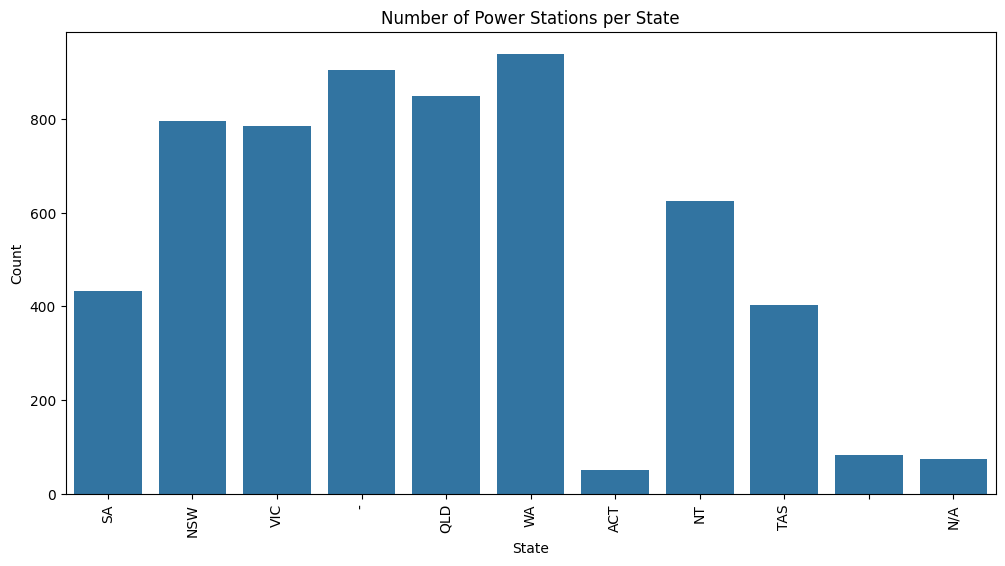

In [180]:
# Plot the number of power stations per state
plt.figure(figsize=(12,6))
sns.countplot(x='state', data=df)
plt.title('Number of Power Stations per State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [182]:
print(df['state'].unique())

['SA' 'NSW' 'VIC' '-' 'QLD' 'WA' 'ACT' 'NT' 'TAS' '' 'N/A']


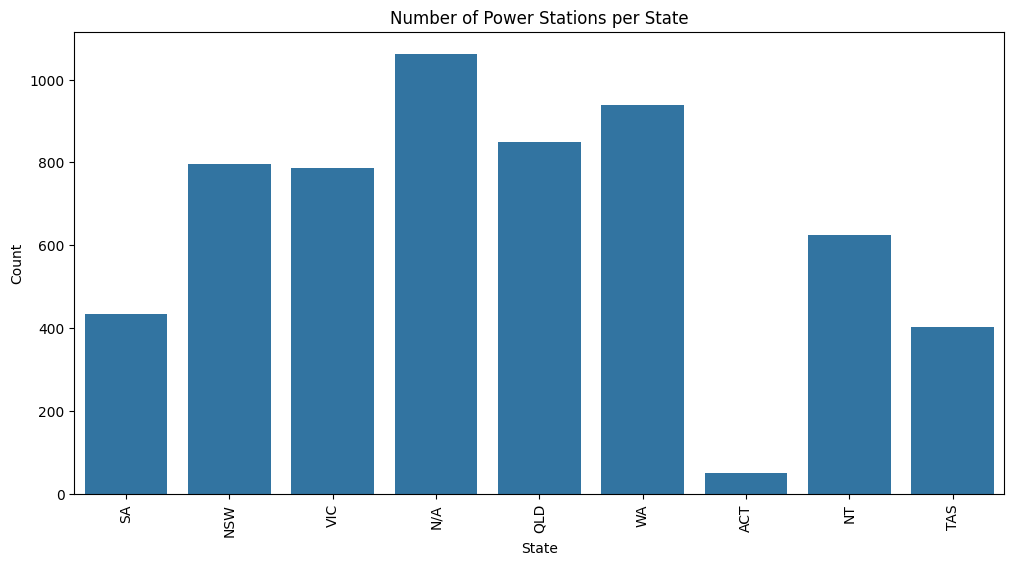

In [184]:
# clean state data
df['state'] = df['state'].replace(['-', ''], 'N/A').fillna('N/A')

# Plot again to see the result
plt.figure(figsize=(12,6))
sns.countplot(x='state', data=df)
plt.title('Number of Power Stations per State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [186]:
# clean facility_name data
# Drop rows where facility_name is "", "-", or null
# Also drop rows where faacility_name is "Corporate Total"
df = df[~df['facility_name'].isin(['', '-', 'Corporate Total']) & df['facility_name'].notna()]

In [188]:
# save to database
df.to_sql(name=gh_energy_table_name, con=db_engine, if_exists='replace', index=False)

880

In [190]:
# Display the first few rows of the table
df.head()

,index,reporting_entity,facility_name,type,state,electricity_production_gj,electricity_production_mwh,total_scope_1_emissions_t_co2_e,total_scope_2_emissions_t_co2_e,total_emissions_t_co2_e,emission_intensity_t_co2_emwh,grid_connected,grid,primary_fuel,important_notes,time_period_start,time_period_stop,dataset_id
0,0,ACCIONA ENERGY OCEANIA PTY LTD,Cathedral Rocks Wind Farm,F,SA,481948.0,133874.0,57.0,127.0,184,0.0,On,NEM,Wind,-,2023-01-07,2024-06-30,ID0243
1,1,ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,491409.0,136502.0,50.0,218.0,268,0.0,On,NEM,Wind,-,2023-01-07,2024-06-30,ID0243
2,2,ACCIONA ENERGY OCEANIA PTY LTD,Mortlake South Wind Farm,F,VIC,1019352.0,283153.0,202.0,1128.0,1330,0.0,On,NEM,Wind,-,2023-01-07,2024-06-30,ID0243
3,3,ACCIONA ENERGY OCEANIA PTY LTD,Mt Gellibrand Wind Farm,F,VIC,1025451.0,284847.0,99.0,1273.0,1372,0.0,On,NEM,Wind,-,2023-01-07,2024-06-30,ID0243
4,4,ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,1954964.0,543046.0,186.0,1114.0,1300,0.0,On,NEM,Wind,-,2023-01-07,2024-06-30,ID0243


## 2001–2024 Accredited power stations data

In [85]:
# Query the table and load into DataFrame
table_name = 'accredited_power_stations_data'
query = f"SELECT * FROM {table_name}"

# Access the power stations table using pandas
df = pd.read_sql(query, con=db_engine)

# Display the first few rows of the table
df.head()

,index,accreditation_code,power_station_name,state,installed_capacity,postcode,fuel_sources,accreditation_start_date,suspension_status,baseline_mwh,comment
0,0,SRPXQLG5,Varsity Views - Solar w SGU - QLD,QLD,0.2109,4227,Solar,2024-12-18,Unsuspended,0,None
1,1,SRPYNS51,NNSWLHD-Byron Central Hospital - Solar - NSW,NSW,0.7203,2481,Solar,2024-12-12,Unsuspended,0,None
2,2,SRPXQLG2,Springwood Terrace Care Community - Solar w SG...,QLD,0.1890,4127,Solar,2024-12-10,Unsuspended,0,None
3,3,SRPYNS45,Bunnings Bennetts Green - Solar - NSW,NSW,0.2800,2290,Solar,2024-12-03,Unsuspended,0,None
4,4,SRPYNS46,Tuggerah Home MSB1 254kW - Solar - NSW,NSW,0.2540,2259,Solar,2024-12-02,Unsuspended,0,None


In [86]:
print(df.columns)

Index(['index', 'accreditation_code', 'power_station_name', 'state',
       'installed_capacity', 'postcode', 'fuel_sources',
       'accreditation_start_date', 'suspension_status', 'baseline_mwh',
       'comment'],
      dtype='object')


In [87]:
# Check for missing values
print(df.isnull().sum())

index                          0
accreditation_code             0
power_station_name             0
state                          0
installed_capacity             0
postcode                       0
fuel_sources                   0
accreditation_start_date       0
suspension_status              0
baseline_mwh                   0
comment                     2841
dtype: int64


In [88]:
# Check for duplicates
print(df.duplicated().sum())

0


In [89]:
# Summary statistics for numeric columns
print(df.describe())

# Count of unique values for categorical columns
print(df['state'].value_counts())
print(df['fuel_sources'].value_counts())
print(df['suspension_status'].value_counts())

             index  installed_capacity     postcode  \
count  3020.000000         3020.000000  3020.000000   
mean   1509.500000           13.309418  3841.687086   
min       0.000000            0.000000   800.000000   
25%     754.750000            0.203675  2650.000000   
50%    1509.500000            0.331200  3618.000000   
75%    2264.250000            1.067000  4871.000000   
max    3019.000000         2000.000000  7469.000000   
std     871.943232           71.014045  1468.979461   

            accreditation_start_date  baseline_mwh  
count                           3020  3.020000e+03  
mean   2018-11-20 13:54:54.834436864  5.511625e+03  
min              2001-04-01 00:00:00  0.000000e+00  
25%              2018-02-22 18:00:00  0.000000e+00  
50%              2020-02-10 00:00:00  0.000000e+00  
75%              2022-12-13 00:00:00  0.000000e+00  
max              2024-12-18 00:00:00  1.319577e+06  
std                              NaN  5.667667e+04  
state
NSW    857
VIC    709

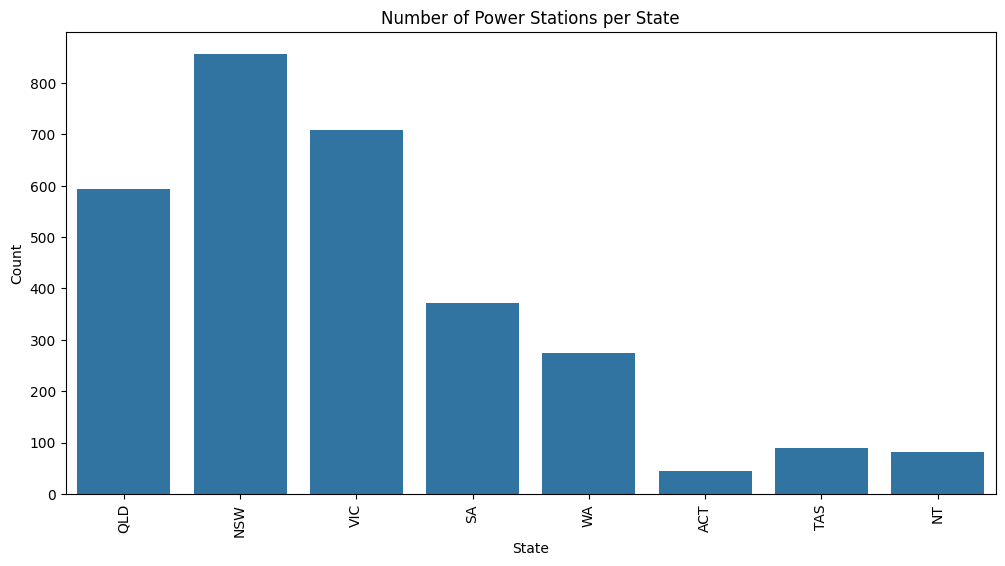

In [90]:
# Plot the number of power stations per state
plt.figure(figsize=(12,6))
sns.countplot(x='state', data=df)
plt.title('Number of Power Stations per State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

## Dataset 3: Australian Bureau of Statistic Data

In [92]:
# Query the table and load into DataFrame
table_name = 'estimated_resident_population'
query = f"SELECT * FROM {table_name}"

# Access the power stations table using pandas
df = pd.read_sql(query, con=db_engine)

# Display the first few rows of the table
df.head()

,index,code,label,year,estimated_resident_population_integer,population_density_personskm2,estimated_resident_population___males_integer,estimated_resident_population___females_integer,median_age___males_years,median_age___females_years,median_age___persons_years,working_age_population_aged_15_64_years_integer,working_age_population_aged_15_64_years_pct,geo_scope
0,0,AUS,Australia,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,AUS,Australia,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2,AUS,Australia,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3,AUS,Australia,2019.0,25334826.0,3.3,12577221.0,12757605.0,36.7,38.4,37.5,16570435.0,65.4,1
4,4,AUS,Australia,2020.0,25649248.0,3.3,12728639.0,12920609.0,37.0,38.7,37.9,16704135.0,65.1,1


In [93]:
print(df.columns)

Index(['index', 'code', 'label', 'year',
       'estimated_resident_population_integer',
       'population_density_personskm2',
       'estimated_resident_population___males_integer',
       'estimated_resident_population___females_integer',
       'median_age___males_years', 'median_age___females_years',
       'median_age___persons_years',
       'working_age_population_aged_15_64_years_integer',
       'working_age_population_aged_15_64_years_pct', 'geo_scope'],
      dtype='object')


In [94]:
print(len(df))

31370


In [95]:
# Check for missing values
print(df.isnull().sum())

index                                                  0
code                                                  12
label                                                 18
year                                                  21
estimated_resident_population_integer              10636
population_density_personskm2                      11192
estimated_resident_population___males_integer      14103
estimated_resident_population___females_integer    14134
median_age___males_years                           14103
median_age___females_years                         14134
median_age___persons_years                         14091
working_age_population_aged_15_64_years_integer    14108
working_age_population_aged_15_64_years_pct        14108
geo_scope                                              0
dtype: int64


In [96]:
# Check for duplicates
print(df.duplicated().sum())

0


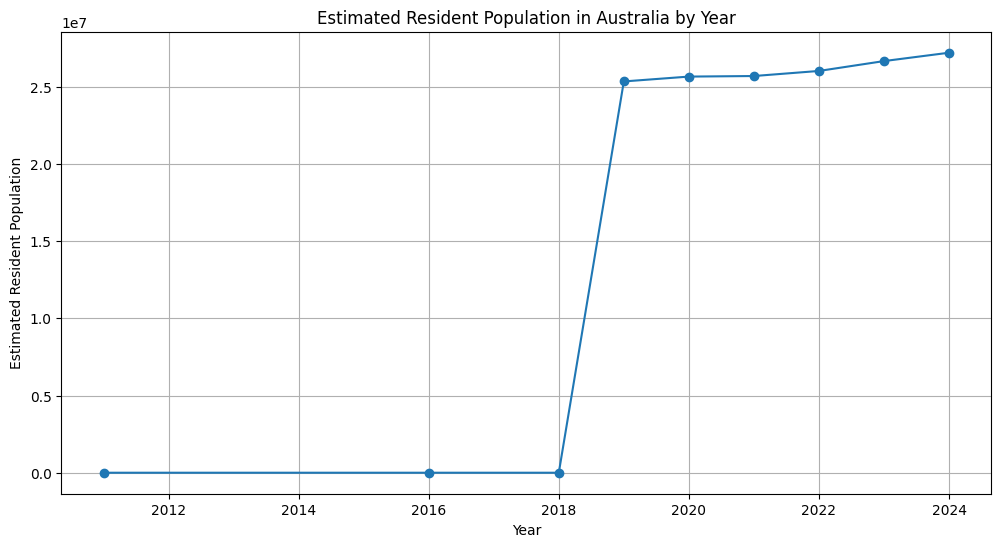

In [97]:
# Filter data for label == 'Australia'
australia_data = df[df['label'] == 'Australia']

# Group by 'year' and sum the 'estimated_resident_population_integer'
australia_population_per_year = australia_data.groupby('year')['estimated_resident_population_integer'].sum().reset_index()

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(australia_population_per_year['year'], australia_population_per_year['estimated_resident_population_integer'], marker='o')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Estimated Resident Population')
plt.title('Estimated Resident Population in Australia by Year')
plt.grid(True)

# Show plot
plt.show()

# 5. Data Augmentation

## 5.1 CER Power Stations

In [139]:
# Funtion to extract state coordinates and output the dictionary
def get_state_coordinates(df, state_col='state', wait=1):
    # Extract unique states
    state_list = df[state_col].dropna().unique().tolist()

    # Initialize dictionary to store results
    state_coords = {}

    # Nominatim API setup
    base_url = 'https://nominatim.openstreetmap.org/search'
    headers = {'User-Agent': 'COMP5339'}

    # Query OpenStreetMap for each state
    for state in state_list:
        # Skip invalid states
        if state in ['-', '', 'N/A']:
            params = {'q': 'Australia', 'format': 'json'}  # Specify Default Value
        else:
            params = {'q': state + ', Australia', 'format': 'json'}  # Specify Australian states
        
        t.sleep(wait)  # Avoid overloading the service
        
        try:
            response = requests.get(base_url, params=params, headers=headers)
            if response.status_code == 200:
                data = response.json()
                if data:
                    lat = float(data[0]['lat'])
                    lon = float(data[0]['lon'])
                    spatial_id = data[0]['osm_id']
                    state_coords[state] = (spatial_id, lat, lon)
                else:
                    state_coords[state] = (None, None, None)
            else:
                state_coords[state] = (None, None, None)
        except:
            state_coords[state] = (None, None, None)

    return state_coords

In [101]:
# Function to return the latitude and longitude of the address using OpenStreetMap Nominatim API
def geocode_osm(address, state, status='Accredited', state_coords=None, wait=1):
    # Base URL for OpenStreetMap Nominatim API
    base_url = 'https://nominatim.openstreetmap.org/search'
    headers = {'User-Agent': 'COMP5339'}

    # Only try OSM lookup if status is 'Accredited'
    if status == 'Accredited':
        params = {'q': f"{address}, {state}", 'format': 'json'}
        t.sleep(wait)
        try:
            print(f'get geocode for {params}..')
            response = requests.get(base_url, params=params, headers=headers)
            if response.status_code == 200:
                data = response.json()
                if data:  # Return first result
                    osm_id = data[0].get('osm_id')
                    lat = float(data[0].get('lat'))
                    lon = float(data[0].get('lon'))
                    return osm_id, lat, lon
        except:
            pass  # silently ignore request errors

    # Fallback to state coordinates
    if state_coords and state in state_coords:
        return state_coords[state]

    # If all fails
    return None, None, None

In [102]:
# Query the table and load into DataFrame
table_name = 'accredited_power_stations_data'
query = f"SELECT * FROM {table_name}"

# Access the power stations table using pandas
accredited_df = pd.read_sql(query, con=db_engine)

# Add identifier
accredited_df['status'] = 'Accredited'

# Display the first few rows of the table
accredited_df.head()

,index,accreditation_code,power_station_name,state,installed_capacity,postcode,fuel_sources,accreditation_start_date,suspension_status,baseline_mwh,comment,status
0,0,SRPXQLG5,Varsity Views - Solar w SGU - QLD,QLD,0.2109,4227,Solar,2024-12-18,Unsuspended,0,None,Accredited
1,1,SRPYNS51,NNSWLHD-Byron Central Hospital - Solar - NSW,NSW,0.7203,2481,Solar,2024-12-12,Unsuspended,0,None,Accredited
2,2,SRPXQLG2,Springwood Terrace Care Community - Solar w SG...,QLD,0.1890,4127,Solar,2024-12-10,Unsuspended,0,None,Accredited
3,3,SRPYNS45,Bunnings Bennetts Green - Solar - NSW,NSW,0.2800,2290,Solar,2024-12-03,Unsuspended,0,None,Accredited
4,4,SRPYNS46,Tuggerah Home MSB1 254kW - Solar - NSW,NSW,0.2540,2259,Solar,2024-12-02,Unsuspended,0,None,Accredited


In [103]:
# Query the table and load into DataFrame
table_name = 'committed_power_stations'
query = f"SELECT * FROM {table_name}"

# Access the power stations table using pandas
comitted_df = pd.read_sql(query, con=db_engine)

# Add identifier
comitted_df['status'] = 'Comitted'

# Rename columns to ensure uniformity
comitted_df = comitted_df.rename(columns={'fuel_source': 'fuel_sources', 'project_name': 'power_station_name'})

comitted_df.head()

,index,power_station_name,state,mw_capacity,fuel_sources,committed_date,status
0,0,East Rockingham Resource Recovery Facility,WA,29.0,Biomass,2019-12-01,Comitted
1,1,Mangalore Renewable Energy Project,VIC,5.0,Solar,2021-09-01,Comitted
2,2,Orange Community Renewable Energy Park,NSW,5.0,Solar,2022-07-01,Comitted
3,3,Moorebank Logistics Park,NSW,60.0,Solar,2022-09-01,Comitted
4,4,Wangaratta Solar Farm,VIC,40.0,Solar,2023-07-01,Comitted


In [104]:
# Query the table and load into DataFrame
table_name = 'probable_power_stations'
query = f"SELECT * FROM {table_name}"

# Access the power stations table using pandas
probable_df = pd.read_sql(query, con=db_engine)

# Add identifier
probable_df['status'] = 'Probable'

# Rename columns to ensure uniformity
probable_df = probable_df.rename(columns={'fuel_source': 'fuel_sources', 'project_name': 'power_station_name'})

probable_df.head()

,index,power_station_name,state,mw_capacity,fuel_sources,status
0,0,Barnawartha Solar Farm,VIC,64.0,Solar,Probable
1,1,Barwon solar farm,VIC,250.0,Solar,Probable
2,2,Boddington Giga Energy,WA,400.0,Solar,Probable
3,3,Bulli Creek Solar project Stage 1,QLD,775.0,Solar,Probable
4,4,Bullyard Solar Farm,QLD,100.0,Solar,Probable


In [105]:
# Concatenate to make power_station df
power_station_df = pd.concat([accredited_df, comitted_df, probable_df], ignore_index=True)
# Convert the float column to string, removing .0 if it's an integer
power_station_df['postcode'] = power_station_df['postcode'].apply(lambda x: str(int(x)) if x.is_integer() else str(x))
power_station_df.head()

,index,accreditation_code,power_station_name,state,installed_capacity,postcode,fuel_sources,accreditation_start_date,suspension_status,baseline_mwh,comment,status,mw_capacity,committed_date
0,0,SRPXQLG5,Varsity Views - Solar w SGU - QLD,QLD,0.2109,4227,Solar,2024-12-18,Unsuspended,0.0,None,Accredited,NaN,NaT
1,1,SRPYNS51,NNSWLHD-Byron Central Hospital - Solar - NSW,NSW,0.7203,2481,Solar,2024-12-12,Unsuspended,0.0,None,Accredited,NaN,NaT
2,2,SRPXQLG2,Springwood Terrace Care Community - Solar w SG...,QLD,0.1890,4127,Solar,2024-12-10,Unsuspended,0.0,None,Accredited,NaN,NaT
3,3,SRPYNS45,Bunnings Bennetts Green - Solar - NSW,NSW,0.2800,2290,Solar,2024-12-03,Unsuspended,0.0,None,Accredited,NaN,NaT
4,4,SRPYNS46,Tuggerah Home MSB1 254kW - Solar - NSW,NSW,0.2540,2259,Solar,2024-12-02,Unsuspended,0.0,None,Accredited,NaN,NaT


In [141]:
# Get unique state coordinates
state_coords = get_state_coordinates(power_station_df, state_col='state', wait=1)

state_coords

{'QLD': (2316595, -22.1646782, 144.5844903),
 'NSW': (2316593, -31.8759835, 147.2869493),
 'VIC': (2316741, -36.5986096, 144.6780052),
 'SA': (2316596, -30.5343665, 135.6301212),
 'WA': (2316598, -25.2303005, 121.0187246),
 'ACT': (2354197, -35.4883502, 149.0026942),
 'TAS': (2369652, -42.035067, 146.6366887),
 'NT': (2316594, -19.8516101, 133.2303375)}

In [107]:
# Apply geocode_osm to each row and unpack results into 'Latitude' and 'Longitude'
power_station_df['spatial_id'], power_station_df['Latitude'], power_station_df['Longitude'] = zip(*power_station_df.apply(lambda row: geocode_osm(row['power_station_name'], row['state'], row['status'], state_coords=state_coords), axis=1))

power_station_df.head()

get geocode for {'q': 'Varsity Views - Solar w SGU - QLD, QLD', 'format': 'json'}..
get geocode for {'q': 'NNSWLHD-Byron Central Hospital - Solar - NSW, NSW', 'format': 'json'}..
get geocode for {'q': 'Springwood Terrace Care Community - Solar w SGU - QLD, QLD', 'format': 'json'}..
get geocode for {'q': 'Bunnings Bennetts Green - Solar - NSW, NSW', 'format': 'json'}..
get geocode for {'q': 'Tuggerah Home MSB1 254kW - Solar - NSW, NSW', 'format': 'json'}..
get geocode for {'q': 'Tuggerah Home MSB2 245.5kW - Solar - NSW, NSW', 'format': 'json'}..
get geocode for {'q': 'Tuggerah Home MSB3 372 kW - Solar - NSW, NSW', 'format': 'json'}..
get geocode for {'q': 'Bunnings Dubbo - Solar - NSW, NSW', 'format': 'json'}..
get geocode for {'q': 'Haymes Paint - Solar w SGU - VIC, VIC', 'format': 'json'}..
get geocode for {'q': 'Lagoons@Port CTS35761 Port Douglas - SOLAR - QLD, QLD', 'format': 'json'}..
get geocode for {'q': 'Southern Steel Pty - Brice Metal - Solar w SGU - SA, SA', 'format': 'json'}

KeyboardInterrupt: 

In [ ]:
# Test connection and check PostGIS status using text() for SQL
with db_engine.connect() as connection:
    result = connection.execute(text("SELECT PostGIS_full_version();"))
    postgis_version = result.fetchone()
    print(f"PostGIS Version: {postgis_version[0]}")

In [ ]:
# Convert lat/lon to PostGIS Point
power_station_df['geom'] = power_station_df.apply(
    lambda row: WKTElement(f"POINT({row['Longitude']} {row['Latitude']})", srid=4326),
    axis=1
)

power_station_df.head()

In [ ]:
table_name = 'spatial_power_stations_data'

# store data to database
power_station_df.to_sql(name=table_name, con=db_engine, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid=4326)})

In [ ]:
# Check Postgis
query = text("SELECT power_station_name, ST_AsText(geom) AS geom_wkt FROM spatial_power_stations_data LIMIT 5;")
df_check = pd.read_sql(query, con=db_engine)
print(df_check)

## 5.2 NGER Data

In [143]:
# Query the table and load into DataFrame
table_name = 'greenhouse_and_energy'
query = f"SELECT * FROM {table_name}"

# Access the power stations table using pandas
nger_df = pd.read_sql(query, con=db_engine)

In [145]:
unique_facility = nger_df[['facility_name', 'state']].drop_duplicates()

unique_facility.head()

,facility_name,state
0,Cathedral Rocks Wind Farm,SA
1,Gunning Wind Farm,NSW
2,Mortlake South Wind Farm,VIC
3,Mt Gellibrand Wind Farm,VIC
4,Waubra Wind Farm,VIC


In [147]:
# Get unique state coordinates
state_coords = get_state_coordinates(unique_facility, state_col='state', wait=1)

state_coords

{'SA': (2316596, -30.5343665, 135.6301212),
 'NSW': (2316593, -31.8759835, 147.2869493),
 'VIC': (2316741, -36.5986096, 144.6780052),
 'N/A': (80500, -24.7761086, 134.755),
 'QLD': (2316595, -22.1646782, 144.5844903),
 'WA': (2316598, -25.2303005, 121.0187246),
 'ACT': (2354197, -35.4883502, 149.0026942),
 'NT': (2316594, -19.8516101, 133.2303375),
 'TAS': (2369652, -42.035067, 146.6366887)}

In [ ]:
# Apply geocode_osm to each row and unpack results into 'Latitude' and 'Longitude'
unique_facility['spatial_id'], unique_facility['Latitude'], unique_facility['Longitude'] = zip(*unique_facility.apply(lambda row: geocode_osm(row['facility_name'], row['state'], state_coords=state_coords), axis=1))

unique_facility.head()

In [ ]:
# Left join back to the full NGER data to get the spatial columns
nger_df = nger_df.merge(
    unique_facility[['facility_name', 'state', 'spatial_id', 'Latitude', 'Longitude']],
    on=['facility_name', 'state'],
    how='left'
)

In [ ]:
# Convert lat/lon to PostGIS Point
nger_df['geom'] = nger_df.apply(
    lambda row: WKTElement(f"POINT({row['Longitude']} {row['Latitude']})", srid=4326),
    axis=1
)

nger_df.head()

In [ ]:
table_name = 'spatial_greenhouse_and_energy'

# store data to database
nger_df.to_sql(name=table_name, con=db_engine, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid=4326)})

# 6. Data Transformation and Storage

## 6.1 Data Transformation

In [ ]:
# Transform location information for loading into the dim_location table 

# Start with the states from NGER and CER data
# Query both tables and combine them into one DataFrame
query = """
SELECT state FROM spatial_greenhouse_and_energy
UNION
SELECT state FROM spatial_power_stations_data
"""

# Access and load into a single DataFrame
states_df = pd.read_sql(query, con=db_engine)

# Get unique state coordinates from the consolidated state list
state_coords = get_state_coordinates(states_df, state_col='state', wait=1)

# Convert the dictionary into a DataFrame with state_code, spatial_id, latitude, and longitude
states_df = pd.DataFrame.from_dict(state_coords, orient='index', columns=['spatial_id', 'Latitude', 'Longitude'])

# Add state_code and reorganize columns
states_df['state_code'] = states_df.index
states_df = states_df[['state_code', 'spatial_id', 'Latitude', 'Longitude']]

# Filter out invalid state_code values and reset index
# states_df = states_df[~states_df['state_code'].isin(['-', '', 'N/A'])].reset_index(drop=True)

# Convert the float column to string, removing .0 if it's an integer
states_df['spatial_id'] = states_df['spatial_id'].apply(lambda x: str(int(x)) if x.is_integer() else str(x))

# Convert lat/lon to PostGIS Point
states_df['geom'] = states_df.apply(
    lambda row: WKTElement(f"POINT({row['Longitude']} {row['Latitude']})", srid=4326),
    axis=1
)

states_df.head()

In [ ]:
# Now get the location information of each facility and power stations
# Query both tables and combine them into one DataFrame
query = f"""
    SELECT "spatial_id", "state" as state_code, "Latitude", "Longitude", "geom", "postcode"
    FROM spatial_power_stations_data
    UNION ALL
    SELECT "spatial_id", "state" as state_code, "Latitude", "Longitude", "geom", NULL as postcode
    FROM spatial_greenhouse_and_energy
"""

# Access the tables and load into a single DataFrame
power_stations_locations_df = pd.read_sql(query, con=db_engine)

# Convert the 'geom' column from WKB hex to geometry (apply once after concatenation)
power_stations_locations_df['geom'] = power_stations_locations_df['geom'].apply(lambda x: wkb.loads(bytes.fromhex(x)))

# Filter out invalid state_code values and reset index
power_stations_locations_df = power_stations_locations_df[~power_stations_locations_df['state_code'].isin(['-', '', 'N/A'])].reset_index(drop=True)

# Convert the float column to string, removing .0 if it's an integer
power_stations_locations_df['spatial_id'] = power_stations_locations_df['spatial_id'].apply(lambda x: str(int(x)) if x.is_integer() else str(x))

# Display the first few rows for verification
power_stations_locations_df.head()

In [ ]:
# Concatenate to make locations df
location_df = pd.concat([power_stations_locations_df, states_df], ignore_index=True)

# Group by 'spatial_id' and take the first non-null value for each column in the group
location_df_grouped = location_df.groupby('spatial_id', as_index=False).first()

# Rename the columns to the desired names
location_df_grouped = location_df_grouped.rename(columns={
    'spatial_id': 'location_id',      # Rename 'spatial_id' to 'location_id'
    'state_code': 'state_code',       # 'state_code' remains the same (or change it if needed)
    'Latitude': 'latitude',           # 'Latitude' to 'latitude'
    'Longitude': 'longitude',         # 'Longitude' to 'longitude'
    'geom': 'geometry'                # 'geom' to 'geometry'
})

# Reorder the columns as needed
dim_location = location_df_grouped[['location_id', 'latitude', 'longitude', 'geometry', 'postcode', 'state_code']]

# Here we're converting the 'geometry' to a valid WKT representation
dim_location['geometry'] = dim_location['geometry'].apply(lambda x: f"POINT({x.x} {x.y})" if x else None)

# Final dim_location table
dim_location.head()

In [ ]:
# Use the tansformed states_df to make the dim_states table
# Create a mapping of state_code to state_name
state_name_mapping = {
    'NSW': 'New South Wales',
    'VIC': 'Victoria',
    'TAS': 'Tasmania',
    'ACT': 'Australian Capital Territory',
    'QLD': 'Queensland',
    'WA': 'Western Australia',
    'SA': 'South Australia',
    'NT': 'Northern Territory',
    'N/A': 'Australia'
}

temp_dim_states_df = states_df

# Add state_name column based on the mapping
temp_dim_states_df['state_name'] = temp_dim_states_df['state_code'].map(state_name_mapping)

# Reorganize columns to match desired format
dim_states = temp_dim_states_df[['state_code', 'state_name']]

# Final dim_states data
dim_states

In [ ]:
# Transform fuel information from NGER and CER for loading into the dim_fuel table 

# Query both tables and combine them into one DataFrame
query = f"""
    SELECT "fuel_sources" as fuel_name
    FROM spatial_power_stations_data
    UNION ALL
    SELECT "primary_fuel" as fuel_name
    FROM spatial_greenhouse_and_energy
"""

# Access the tables and load into a single DataFrame
fuel_df = pd.read_sql(query, con=db_engine)

# Group by 'fuel_name' and take the first non-null value for each column in the group
fuel_df = fuel_df.groupby('fuel_name', as_index=False).first()

# Filter out invalid fuel_name values and reset index
fuel_df = fuel_df[~fuel_df['fuel_name'].isin(['-', '', 'N/A'])].reset_index(drop=True)

# Assign a unique fuel_id to each distinct fuel_name
fuel_df['fuel_id'] = range(1, len(fuel_df) + 1)

# Reorganize columns to match desired format
dim_fuel = fuel_df[['fuel_id', 'fuel_name']]

# Final dim_fuel table
dim_fuel.head()

In [ ]:
# Transform date information from NGER and CER for loading into the dim_time table 
# Query both tables and combine them into one DataFrame
query = """
    SELECT "accreditation_start_date" AS date_1, "committed_date" AS date_2
    FROM spatial_power_stations_data
    UNION ALL
    SELECT "time_period_start" AS date_1, "time_period_stop" AS date_2
    FROM spatial_greenhouse_and_energy
"""

# Access the tables and load into a single DataFrame
time_df = pd.read_sql(query, con=db_engine)

# Melt the DataFrame to create a single column for dates
time_df_melted = time_df.melt(value_name='date', var_name='date_type')

# Drop the date_type column if not needed
time_df_melted = time_df_melted.drop(columns=['date_type'])

# Group by 'date' to ensure no duplicates (keep first value for each date)
time_df_melted = time_df_melted.groupby('date', as_index=False).first()

# Ensure 'date' is in datetime format
time_df_melted['date'] = pd.to_datetime(time_df_melted['date'])

# Drop rows with NaN/NaT values in the 'date' column
time_df_melted = time_df_melted.dropna(subset=['date'])

# Extract the required components
time_df_melted['day'] = time_df_melted['date'].dt.day
time_df_melted['month'] = time_df_melted['date'].dt.month
time_df_melted['month_name'] = time_df_melted['date'].dt.month_name()
time_df_melted['quarter'] = time_df_melted['date'].dt.quarter
time_df_melted['year'] = time_df_melted['date'].dt.year
time_df_melted['week_of_year'] = time_df_melted['date'].dt.isocalendar().week
time_df_melted['day_of_week'] = time_df_melted['date'].dt.weekday + 1  # Monday=1, Sunday=7
time_df_melted['day_name'] = time_df_melted['date'].dt.day_name()
time_df_melted['is_weekend'] = time_df_melted['day_of_week'].isin([6, 7])  # Saturday=6, Sunday=7

# Create time_id (usually in YYYYMMDD format)
time_df_melted['time_id'] = time_df_melted['date'].dt.strftime('%Y%m%d').astype(int)

# Reorder columns to match desired structure for dim_time
dim_time = time_df_melted[['time_id', 'date', 'day', 'month', 'month_name', 'quarter', 'year', 'week_of_year', 'day_of_week', 'day_name', 'is_weekend']]

# Final dim_time table
dim_time.head()

In [ ]:
# Transform power station data from CER for loading into the dim_cer_station table 
# Query the table and set it into a DataFrame
query = """
    SELECT *
    FROM spatial_power_stations_data
"""

# Access the tables and load into a single DataFrame
cer_df = pd.read_sql(query, con=db_engine)

# Filter out rows with NaN in 'power_station_name' to avoid issues with composite_key
cer_df = cer_df[cer_df['power_station_name'].notna()]

# Create a unique combination of 'accreditation_code' and 'power_station_name'
cer_df['composite_key'] = cer_df['power_station_name'].str.cat(
    cer_df['accreditation_code'].fillna('A station_'), sep="_"
)

# Get unique combinations of the composite key
unique_combinations = cer_df['composite_key'].drop_duplicates()

# Assign sequential IDs to each unique combination
location_id_mapping = pd.Series(range(1, len(unique_combinations) + 1), index=unique_combinations).to_dict()

# Map the location_id back to the original DataFrame based on the composite key
cer_df['cer_station_code'] = cer_df['composite_key'].map(location_id_mapping)

# Create time_id (in YYYYMMDD format) for accreditation_start_date and comitted_id, leaving NaN as null
cer_df['accreditation_start_date_id'] = cer_df['accreditation_start_date'].apply(
    lambda x: x.strftime('%Y%m%d') if pd.notna(x) else np.nan
).astype('Int64')

cer_df['committed_date_id'] = cer_df['committed_date'].apply(
    lambda x: x.strftime('%Y%m%d') if pd.notna(x) else np.nan
).astype('Int64')

# Now, merge cer_df with dim_fuel to get the fuel_id based on fuel_sources (fuel_name)
cer_df = cer_df.merge(dim_fuel, how='left', left_on='fuel_sources', right_on='fuel_name')

# Drop the 'fuel_name' and 'fuel_sources' column as it's no longer needed
cer_df = cer_df.drop(columns=['fuel_name', 'fuel_sources'])

# Rename the columns
cer_df = cer_df.rename(columns={
    'spatial_id': 'location_id', 
    'power_station_name': 'station_name'
})

# Reorder columns to match desired structure for dim_time
dim_cer_station = cer_df[['cer_station_code', 'accreditation_code', 'station_name', 'status', 'accreditation_start_date_id', 'baseline_mwh', 'installed_capacity', 'committed_date_id', 'suspension_status', 'fuel_id', 'location_id']]

dim_cer_station.head()

In [ ]:
# Transform power station data from NGER for loading into the dim_nger_facility table 
# Query the table and set it into a DataFrame
query = """
    SELECT *
    FROM spatial_greenhouse_and_energy
"""


# Access the tables and load into a single DataFrame
nger_df = pd.read_sql(query, con=db_engine)

# Rename the columns
nger_df = nger_df.rename(columns={
    'spatial_id': 'location_id'
})

# Now, merge cer_df with dim_fuel to get the fuel_id based on primary_fuel
nger_df = nger_df.merge(dim_fuel, how='left', left_on='primary_fuel', right_on='fuel_name')

# Drop the 'fuel_name' and 'primary_fuel' columns as it's no longer needed
nger_df = nger_df.drop(columns=['fuel_name', 'primary_fuel'])

# Reorder columns to match desired structure for dim_time
dim_nger_df = nger_df[['reporting_entity', 'facility_name', 'type', 'grid', 'fuel_id', 'location_id']]

# Ensure location_id stays null if NaN, otherwise convert to string
dim_nger_df['location_id'] = dim_nger_df['location_id'].apply(
    lambda x: str(int(x)) if pd.notna(x) and isinstance(x, (float, int)) and x.is_integer() else str(x) if pd.notna(x) else np.nan
)

# Replace NaN values in the grouping columns with 'None' as a placeholder
dim_nger_df['reporting_entity'] = dim_nger_df['reporting_entity'].fillna('None')
dim_nger_df['facility_name'] = dim_nger_df['facility_name'].fillna('None')
dim_nger_df['type'] = dim_nger_df['type'].fillna('None')
dim_nger_df['grid'] = dim_nger_df['grid'].fillna('None')
dim_nger_df['fuel_id'] = dim_nger_df['fuel_id'].fillna('None')
dim_nger_df['location_id'] = dim_nger_df['location_id'].fillna('None')

# Group by the specified columns
dim_nger_facility = dim_nger_df.groupby(
    ['reporting_entity', 'facility_name', 'type', 'grid', 'fuel_id', 'location_id']
).first().reset_index()

# Assign a unique fuel_id to each distinct fuel_name
dim_nger_facility['nger_facility_id'] = range(1, len(dim_nger_facility) + 1)

# Save a temp table to create the fact table
dim_nger_facility_copy = dim_nger_facility.copy()

# Convert 'None' placeholders back to NaN for 'fuel_id' and 'location_id'
dim_nger_facility['fuel_id'] = dim_nger_facility['fuel_id'].replace('None', np.nan).astype('Int64')
dim_nger_facility['location_id'] = dim_nger_facility['location_id'].replace('None', np.nan).astype('Int64')

# Reorder columns to match desired structure for dim_time
dim_nger_facility = dim_nger_facility[['nger_facility_id', 'reporting_entity', 'facility_name', 'type', 'grid', 'fuel_id', 'location_id']]

# Final dim_nger_facility table
dim_nger_facility

In [ ]:
# Transform the detail NGER data for loading into the fact_nger_metrics table 

# Ensure location_id stays null if NaN, otherwise convert to string
nger_df['location_id'] = nger_df['location_id'].apply(
    lambda x: str(int(x)) if pd.notna(x) and isinstance(x, (float, int)) and x.is_integer() else str(x) if pd.notna(x) else np.nan
)

# Replace NaN values in the grouping columns with 'None' as a placeholder
nger_df['reporting_entity'] = nger_df['reporting_entity'].fillna('None')
nger_df['facility_name'] = nger_df['facility_name'].fillna('None')
nger_df['type'] = nger_df['type'].fillna('None')
nger_df['grid'] = nger_df['grid'].fillna('None')
nger_df['fuel_id'] = nger_df['fuel_id'].fillna('None')
nger_df['location_id'] = nger_df['location_id'].fillna('None')

# Create composite key, skipping NaN values for each column
nger_df['composite_key'] = nger_df.apply(
    lambda row: '_'.join(
        [str(row['reporting_entity']) if pd.notna(row['reporting_entity']) else '',
         str(row['facility_name']) if pd.notna(row['facility_name']) else '',
         str(row['type']) if pd.notna(row['type']) else '',
         str(row['grid']) if pd.notna(row['grid']) else '',
         str(row['fuel_id']) if pd.notna(row['fuel_id']) else '',
         str(row['location_id']) if pd.notna(row['location_id']) else '']
    ), axis=1
)

# Clean up the composite_key by removing unnecessary leading/trailing underscores
nger_df['composite_key'] = nger_df['composite_key'].str.strip('_')

# Now, merge with dim_nger_facility to get the nger_facility_id
temp_dim_nger_facility = dim_nger_facility_copy.copy()

# Create composite key for temp_dim_nger_facility
temp_dim_nger_facility['composite_key'] = temp_dim_nger_facility.apply(
    lambda row: '_'.join(
        [str(row['reporting_entity']) if pd.notna(row['reporting_entity']) else '',
         str(row['facility_name']) if pd.notna(row['facility_name']) else '',
         str(row['type']) if pd.notna(row['type']) else '',
         str(row['grid']) if pd.notna(row['grid']) else '',
         str(row['fuel_id']) if pd.notna(row['fuel_id']) else '',
         str(row['location_id']) if pd.notna(row['location_id']) else '']
    ), axis=1
)

# Clean up the composite_key by removing unnecessary leading/trailing underscores
temp_dim_nger_facility['composite_key'] = temp_dim_nger_facility['composite_key'].str.strip('_')

# Convert 'None' placeholders back to NaN for 'fuel_id' and 'location_id'
nger_df['fuel_id'] = nger_df['fuel_id'].replace('None', np.nan).astype('Int64')
nger_df['location_id'] = nger_df['location_id'].replace('None', np.nan).astype('Int64')

# Now, merge cer_df with dim_nger_facility to get the nger_facility_id based on composite_key
nger_df = nger_df.merge(temp_dim_nger_facility[['composite_key', 'nger_facility_id']], 
                        how='left', 
                        left_on='composite_key', 
                        right_on='composite_key')

# Assign a unique nger_entry_id to each row
nger_df['nger_entry_id'] = range(1, len(nger_df) + 1)

# Create time_id (in YYYYMMDD format) for time_period_start and time_period_stop, leaving NaN as null
nger_df['time_period_start_id'] = nger_df['time_period_start'].apply(
    lambda x: x.strftime('%Y%m%d') if pd.notna(x) else np.nan
).astype('Int64')

nger_df['time_period_stop_id'] = nger_df['time_period_stop'].apply(
    lambda x: x.strftime('%Y%m%d') if pd.notna(x) else np.nan
).astype('Int64')

# Rename the columns
nger_df = nger_df.rename(columns={
    'total_scope_1_emissions_t_co2_e': 'total_co2_emissions_tons_scope_1',
    'total_scope_2_emissions_t_co2_e': 'total_co2_emissions_tons_scope_2',
    'total_emissions_t_co2_e': 'total_co2_emissiions_tons'
})

# Reorder columns to match desired structure for dim_time
fact_nger_metrics = nger_df[['nger_entry_id', 'nger_facility_id', 'time_period_start_id', 'time_period_stop_id', 'electricity_production_mwh', 'electricity_production_gj', 'total_co2_emissions_tons_scope_1', 'total_co2_emissions_tons_scope_2', 'total_co2_emissiions_tons', 'emission_intensity_t_co2_emwh']]

# Final dim_nger_facility table
fact_nger_metrics.head()

In [ ]:
# Transform demographic data from abs for loading into the fact_population table 
# Query the table and set it into a DataFrame
query = """
    SELECT *
    FROM estimated_resident_population
"""

# Access the tables and load into a single DataFrame
abs_df = pd.read_sql(query, con=db_engine)

# List of columns to check
columns_to_check = [
    'year', 'estimated_resident_population_integer', 'population_density_personskm2',
    'estimated_resident_population___males_integer', 'estimated_resident_population___females_integer',
    'median_age___males_years', 'median_age___females_years', 'median_age___persons_years',
    'working_age_population_aged_15_64_years_integer', 'working_age_population_aged_15_64_years_pct'
]

# Replace 'None' with np.nan for consistency if needed
abs_df[columns_to_check] = abs_df[columns_to_check].replace('None', np.nan)

# Drop rows where all specified columns are NaN
abs_df = abs_df.dropna(subset=columns_to_check, how='all')

# Update the 'code' column where the 'label' matches a state name in the mapping
abs_df['code'] = abs_df.apply(
    lambda row: [key for key, value in state_name_mapping.items() if value == row['label']][0] 
    if row['label'] in state_name_mapping.values() else row['code'],
    axis=1
)

# Rename the columns
abs_df = abs_df.rename(columns={
    'code': 'area_code',
    'estimated_resident_population_integer': 'estimated_resident_population',
    'population_density_personskm2': 'population_density_persons_km2',
    'estimated_resident_population___males_integer': 'estimated_resident_population_male',
    'estimated_resident_population___females_integer': 'estimated_resident_population_female',
    'median_age___males_years': 'median_age_male',
    'median_age___females_years': 'median_age_female',
    'median_age___persons_years': 'median_age',
    'working_age_population_aged_15_64_years_integer': 'working_age_number',
    'working_age_population_aged_15_64_years_pct': 'working_age_percentage'
})

# Assign a unique abs_entry_id to each distinct fuel_name
abs_df['abs_entry_id'] = range(1, len(abs_df) + 1)

# Reorder columns to match desired structure for dim_time
fact_population = abs_df[['abs_entry_id', 'area_code', 'geo_scope', 'year', 'estimated_resident_population', 'estimated_resident_population_male', 'estimated_resident_population_female', 'median_age', 'median_age_male', 'median_age_female', 'working_age_number', 'working_age_percentage']]

# Final fact_population table
fact_population.head()

## 6.2 Data Storage

In [ ]:
try:
    # Connect to the default "postgres" database
    conn = psycopg2.connect(
        dbname="postgres", 
        user=db_user, 
        password=db_password, 
        host=db_host, 
        port=db_port
    )
    conn.autocommit = True

    cur = conn.cursor()
    # Create "energydb"
    cur.execute("CREATE DATABASE energydb;")
    cur.close()
    conn.close()

    # Now connect to "energydb" and enable PostGIS
    energy_conn = psycopg2.connect(
        dbname="energydb",
        user=db_user,
        password=db_password,
        host=db_host,
        port=db_port
    )
    energy_conn.autocommit = True
    energy_cur = energy_conn.cursor()
    energy_cur.execute("CREATE EXTENSION postgis;")
    energy_cur.close()
    energy_conn.close()

except psycopg2.errors.DuplicateDatabase:
    print("Database already exists, skipping creation.")

In [ ]:
# Connect with the new energy db
energy_db_name = "energydb"
energy_db_engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{energy_db_name}')
gh_inspector = inspect(energy_db_engine)

In [ ]:
with energy_db_engine.connect() as connection:
    connection.execute(text("CREATE EXTENSION IF NOT EXISTS postgis;"))

In [ ]:
# Test connection and check PostGIS status using text() for SQL
with energy_db_engine.connect() as connection:
    result = connection.execute(text("SELECT PostGIS_full_version();"))
    postgis_version = result.fetchone()
    print(f"PostGIS Version: {postgis_version[0]}")

In [ ]:
# Create the tables for our schema

# Dimension Tables

dim_fuel_sql = """
CREATE TABLE IF NOT EXISTS dim_fuel (
    fuel_id SERIAL PRIMARY KEY,
    fuel_name TEXT
);
"""

dim_cer_station_sql = """
CREATE TABLE IF NOT EXISTS dim_cer_station (
    cer_station_code BIGSERIAL PRIMARY KEY,
    accreditation_code TEXT,
    station_name TEXT,
    accreditation_start_date_id BIGINT,
    committed_date_id BIGINT,
    status TEXT,
    baseline_mwh FLOAT,
    installed_capacity FLOAT,
    suspension_status TEXT,
    fuel_id BIGINT,
    location_id BIGINT,
    FOREIGN KEY (fuel_id) REFERENCES dim_fuel(fuel_id)
);
"""

dim_state_sql = """
CREATE TABLE IF NOT EXISTS dim_state (
    state_code TEXT PRIMARY KEY,
    state_name TEXT
);
"""

dim_location_sql = """
CREATE TABLE IF NOT EXISTS dim_location (
    location_id BIGSERIAL PRIMARY KEY,
    latitude FLOAT,
    longitude FLOAT,
    geometry GEOMETRY(POINT, 4326),
    postcode TEXT, -- Nullable
    state_code TEXT, -- Foreign Key to dim_state
    FOREIGN KEY (state_code) REFERENCES dim_state(state_code)
);
"""

dim_nger_facility_sql = """
CREATE TABLE IF NOT EXISTS dim_nger_facility (
    nger_facility_id SERIAL PRIMARY KEY,
    reporting_entity TEXT,
    facility_name TEXT,
    type TEXT,
    grid TEXT,
    fuel_id INT, -- A foreign key to dim_fuel
    location_id BIGINT, -- A foreign key to dim_location
    FOREIGN KEY (fuel_id) REFERENCES dim_fuel(fuel_id),
    FOREIGN KEY (location_id) REFERENCES dim_location(location_id)
);
"""

dim_time_sql = """
CREATE TABLE IF NOT EXISTS dim_time (
    time_id INT PRIMARY KEY,
    date DATE,
    day INT,
    month INT,
    month_name TEXT,
    quarter INT,
    year INT,
    week_of_year INT,
    day_of_week INT,
    day_name TEXT,
    is_weekend BOOLEAN
);
"""

# Fact Tables

fact_nger_metrics_sql = """
CREATE TABLE IF NOT EXISTS fact_nger_metrics (
    nger_entry_id SERIAL PRIMARY KEY,
    nger_facility_id INT, -- Foreign Key to dim_nger_facility
    time_period_start_id INT, -- Foreign Key to dim_time
    time_period_stop_id INT, -- Foreign Key to dim_time
    electricity_production_mwh FLOAT,
    electricity_production_gj FLOAT,
    total_emissions_tons FLOAT,
    total_co2_emissions_tons_scope_1 FLOAT,
    total_co2_emissions_tons_scope_2 FLOAT,
    total_co2_emissions_tons FLOAT,
    emission_intensity_t_co2_emwh FLOAT,
    FOREIGN KEY (nger_facility_id) REFERENCES dim_nger_facility(nger_facility_id),
    FOREIGN KEY (time_period_start_id) REFERENCES dim_time(time_id),
    FOREIGN KEY (time_period_stop_id) REFERENCES dim_time(time_id)
);
"""

fact_population_sql = """
CREATE TABLE IF NOT EXISTS fact_population (
    abs_entry_id SERIAL PRIMARY KEY,
    area_code TEXT, -- Foreign Key to dim_state
    geo_scope INT,
    year INT,
    estimated_resident_population INT,
    estimated_resident_population_male INT,
    estimated_resident_population_female INT,
    population_density_persons_km2 FLOAT,
    median_age FLOAT,
    median_age_male FLOAT,
    median_age_female FLOAT,
    working_age_number INT,
    working_age_percentage FLOAT,
    FOREIGN KEY (area_code) REFERENCES dim_state(state_code)
);
"""

# Execute the SQL to create tables
with energy_db_engine.begin() as connection:
    try:
        connection.execute(text(dim_fuel_sql))
        connection.execute(text(dim_cer_station_sql))
        connection.execute(text(dim_state_sql))
        connection.execute(text(dim_location_sql))
        connection.execute(text(dim_nger_facility_sql))
        connection.execute(text(dim_time_sql))
        connection.execute(text(fact_nger_metrics_sql))
        connection.execute(text(fact_population_sql))
    except Exception as e:
        print("Error during table creation:", e)

In [ ]:
# Safe truncate of tables while preserving schema
with energy_db_engine.begin() as conn:  # `begin()` ensures transactional integrity
    conn.execute(text("TRUNCATE TABLE dim_fuel CASCADE"))
    conn.execute(text("TRUNCATE TABLE dim_cer_station CASCADE"))
    conn.execute(text("TRUNCATE TABLE dim_state CASCADE"))
    conn.execute(text("TRUNCATE TABLE dim_location CASCADE"))
    conn.execute(text("TRUNCATE TABLE dim_nger_facility CASCADE"))
    conn.execute(text("TRUNCATE TABLE dim_time CASCADE"))
    conn.execute(text("TRUNCATE TABLE fact_nger_metrics CASCADE"))
    conn.execute(text("TRUNCATE TABLE fact_population CASCADE"))

# Now insert the data into the tables
dim_fuel.to_sql('dim_fuel', con=energy_db_engine, if_exists='append', index=False)
dim_cer_station.to_sql('dim_cer_station', con=energy_db_engine, if_exists='append', index=False)
dim_states.to_sql('dim_state', con=energy_db_engine, if_exists='append', index=False)
dim_location.to_sql('dim_location', con=energy_db_engine, if_exists='append', index=False)
dim_nger_facility.to_sql('dim_nger_facility', con=energy_db_engine, if_exists='append', index=False)
dim_time.to_sql('dim_time', con=energy_db_engine, if_exists='append', index=False)
fact_nger_metrics.to_sql('fact_nger_metrics', con=energy_db_engine, if_exists='append', index=False)
fact_population.to_sql('fact_population', con=energy_db_engine, if_exists='append', index=False)

print("Data inserted successfully.")

In [ ]:
print(dim_location.dtypes)

In [ ]:
dim_nger_facility.head()

In [ ]:
dim_nger_facility.loc[dim_nger_facility['location_id'] == 19396934]

In [ ]:
dim_location.loc[dim_location['location_id'] == 19396934]